joint plot from scRNAseq data

In [ ]:
import sys
sys.path.append("../code")
from code.data_prep.io import *
from code.data_prep.processing import *
from code.plotting.plot_settings import *
from code.plotting.palette import *

In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sc.settings.verbosity=3

In [2]:
import sys
sys.path.append("code")
import settings
from plot_funcs import marker_violins
from plot_funcs import fix_aspect_scatter_with_legend
from plot_funcs import save_figure

sc.set_figure_params(dpi=150, color_map='Reds')
sns.set_style("white")
matplotlib.rcParams["figure.facecolor"]="white"

In [11]:
main_dir = "/projects/robson-lab/research/endometriosis/"
sample_id = "Endometriosis-revision-3"

sc.settings.figdir = f"{main_dir}figures/{sample_id}"

In [12]:
mye = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Myeloid/{sample_id}-final-mye-20220103.h5ad")

In [14]:
iDC = mye[(mye.obs.sample_type.isin(["Ectopic","Ectopic Adj"])) & (mye.obs.subtypes == "cDC2")].copy()
iDC.obs["immunogenic"] = (iDC[:, "CD207"].layers["raw"].sum(axis=1) > 0).A1.astype(bool)
iDC.obs["immunosupressive"] = (iDC[:, "MSR1"].layers["raw"].sum(axis=1) > 0).A1.astype(bool)
iDC.obs["state"] = (2*iDC.obs.immunogenic.astype(int) + iDC.obs.immunosupressive.astype(int)).map({
    0: "negative", 1: "MSR1+", 2: "CD207+", 3: "double positive"}).astype("category")

#keep for DE analysis
keep = np.logical_xor(iDC.obs.immunogenic, iDC.obs.immunosupressive)
subset = iDC[keep,:]
subset.obs["state"] = subset.obs.immunosupressive.map({
    True:"MSR1+",
    False:"CD207+"
})

Trying to set attribute `.obs` of view, copying.


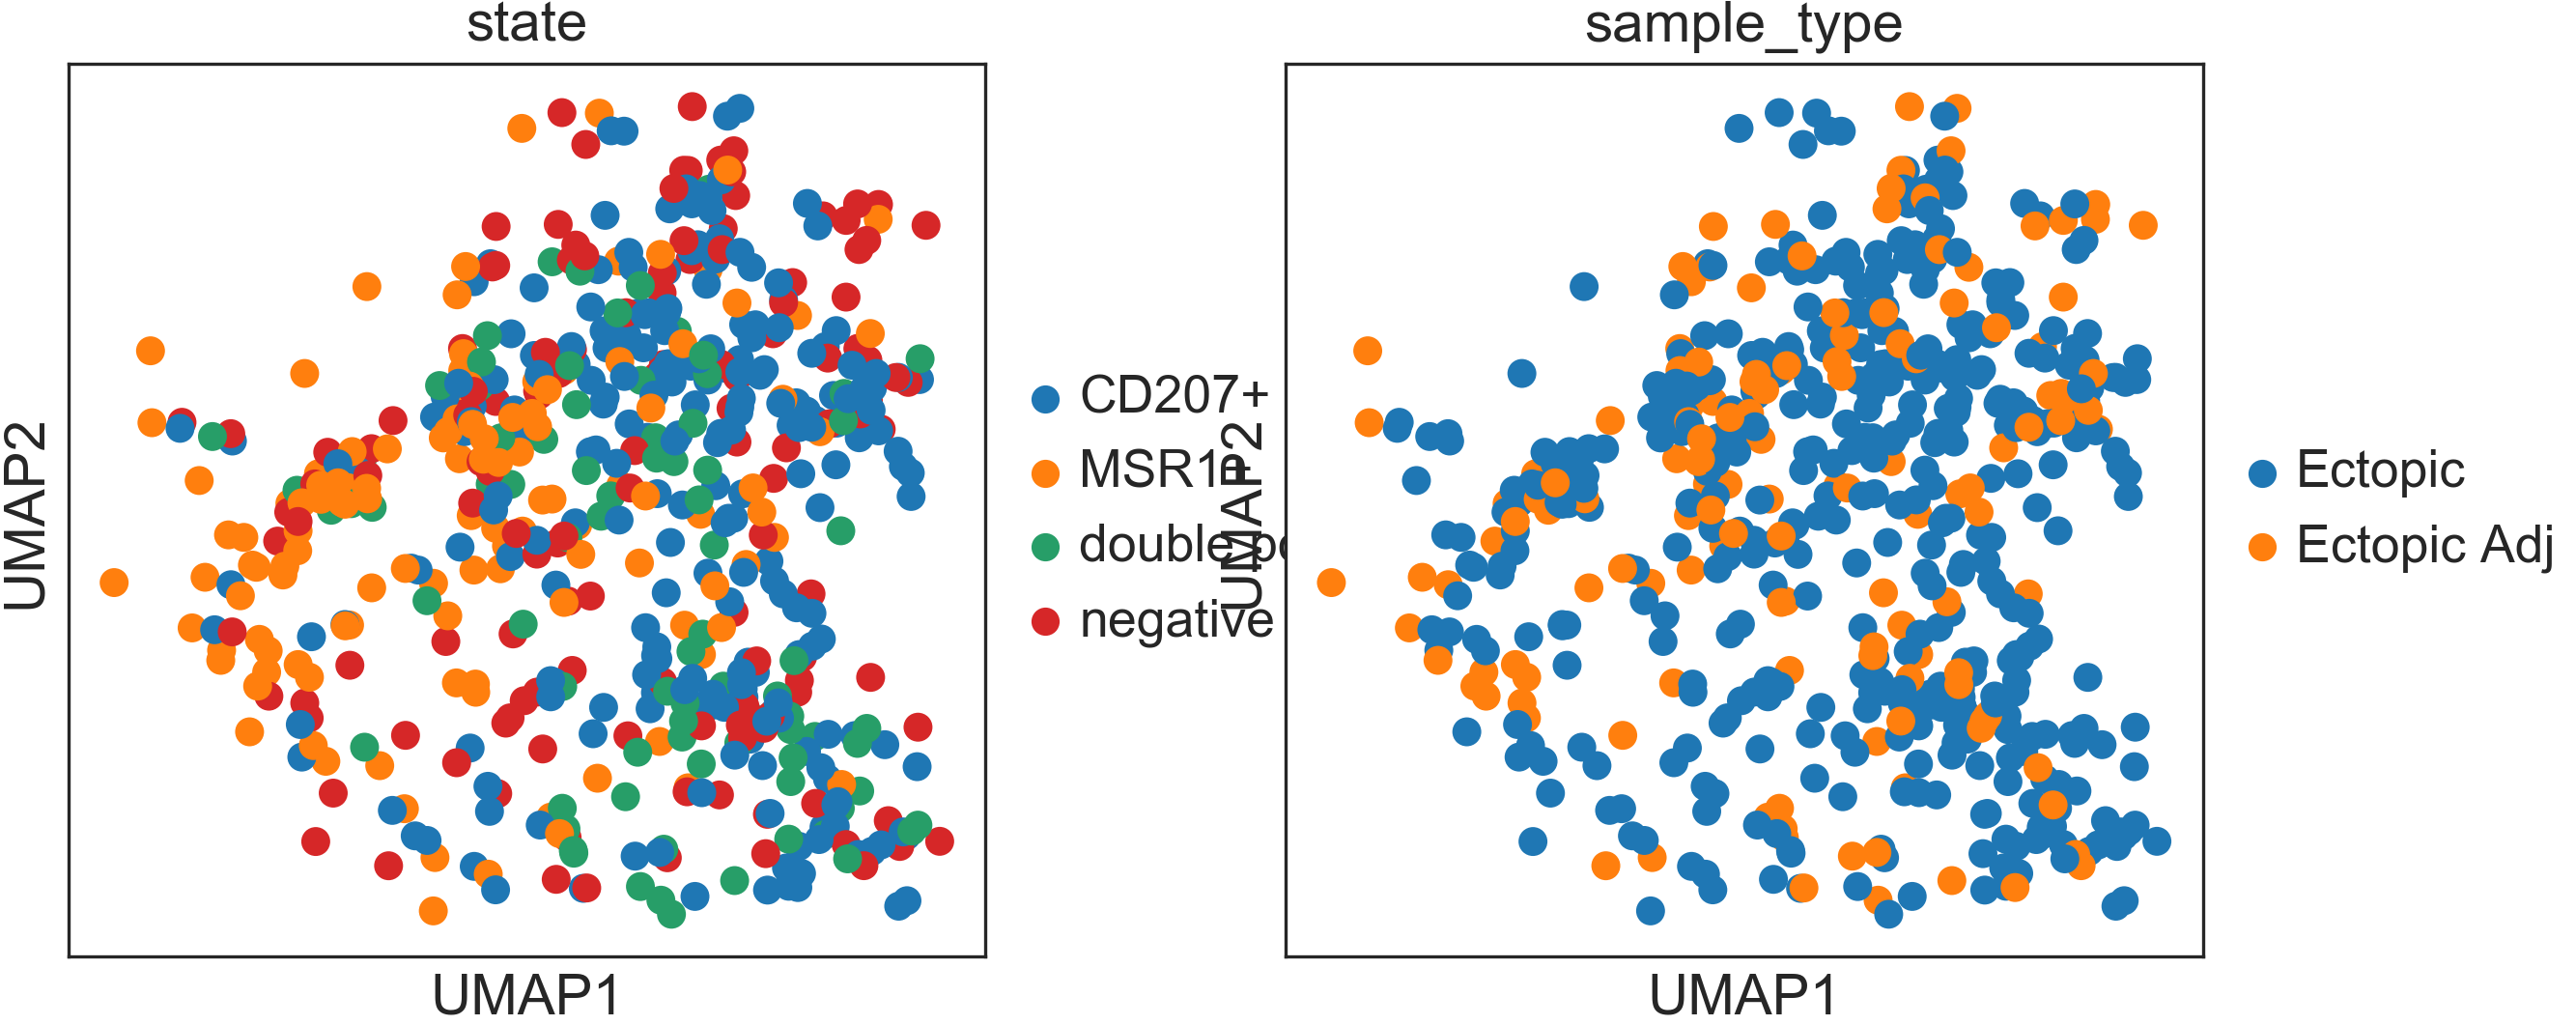

In [30]:
sc.pl.umap(iDC, color=["state", "sample_type"])

In [31]:
full = preprocess(iDC, n_top_genes=1000)
save_adata(full, "cDC2-subset", subdir = "Myeloid")

filtered out 6074 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


#### Batch Corrections & UMAP Computing

In [32]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
sc.pp.pca(full, svd_solver="arpack",use_highly_variable=True)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


In [34]:
pcs = full.obsm["X_pca"]
metadata = full.obs
covariates = ["Patient_id","stage"]
thetas = np.array([2,1])

In [35]:
%%R -i pcs -i covariates -i thetas -i metadata -o pcs_harmony
library(harmony)
pcs_harmony <- HarmonyMatrix(
    pcs,
    metadata,
    vars_use=covariates,
    theta=thetas,
    do_pca=FALSE
)

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [37]:
harmonized = load_pcs(full, pcs_harmony)

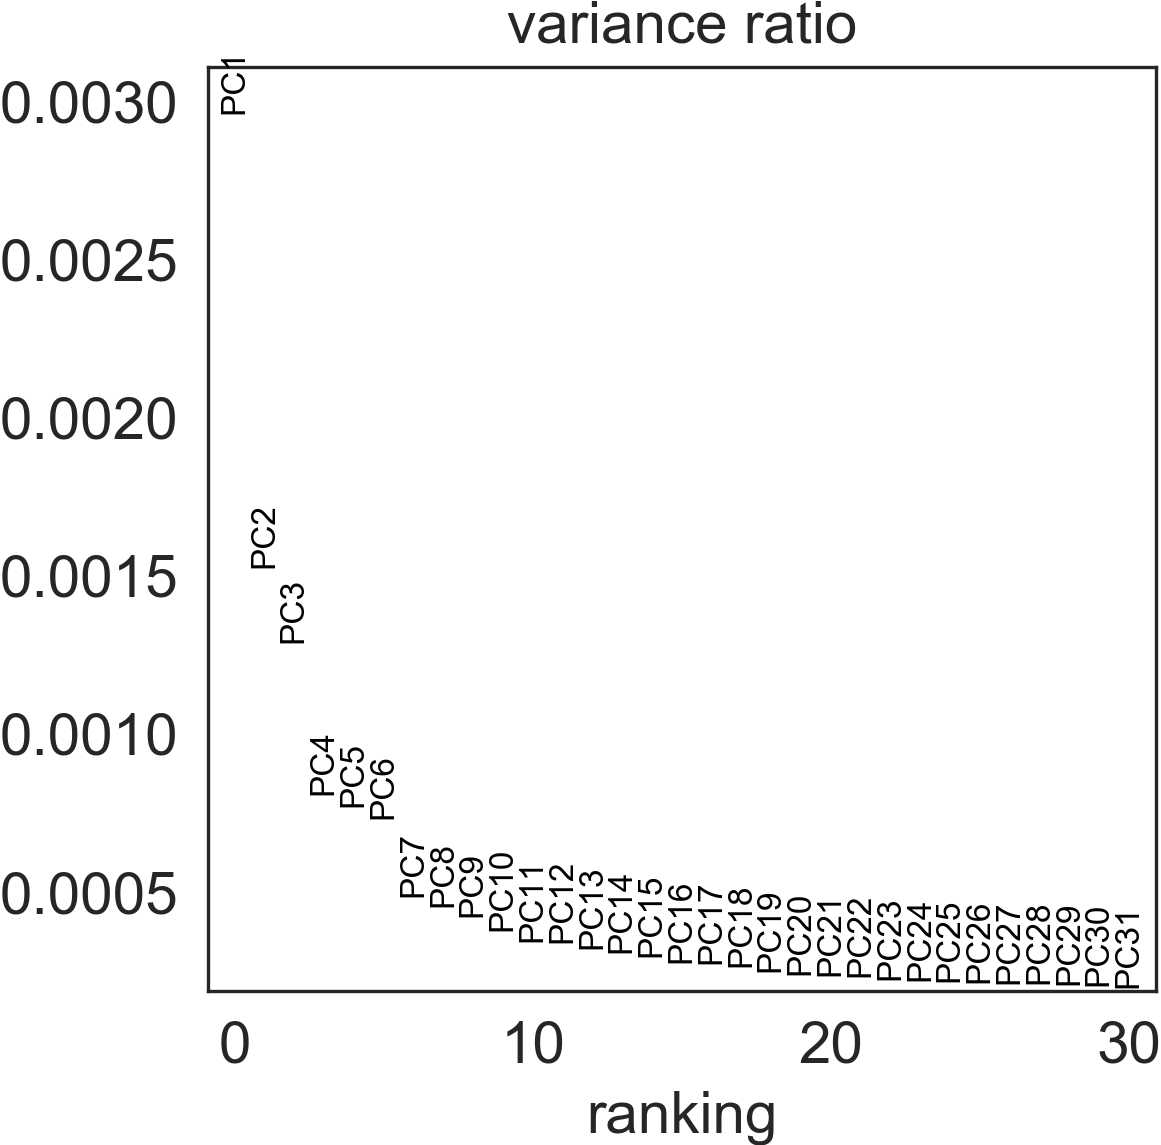

In [38]:
sc.pl.pca_variance_ratio(harmonized,show=False)

In [ ]:
sc.pp.neighbors(harmonized, n_neighbors=15, n_pcs=8, metric="correlation")
sc.tl.umap(harmonized, min_dist=0.5)

computing density on 'umap'
--> added
    'umap_density_state', densities (adata.obs)
    'umap_density_state_params', parameter (adata.uns)


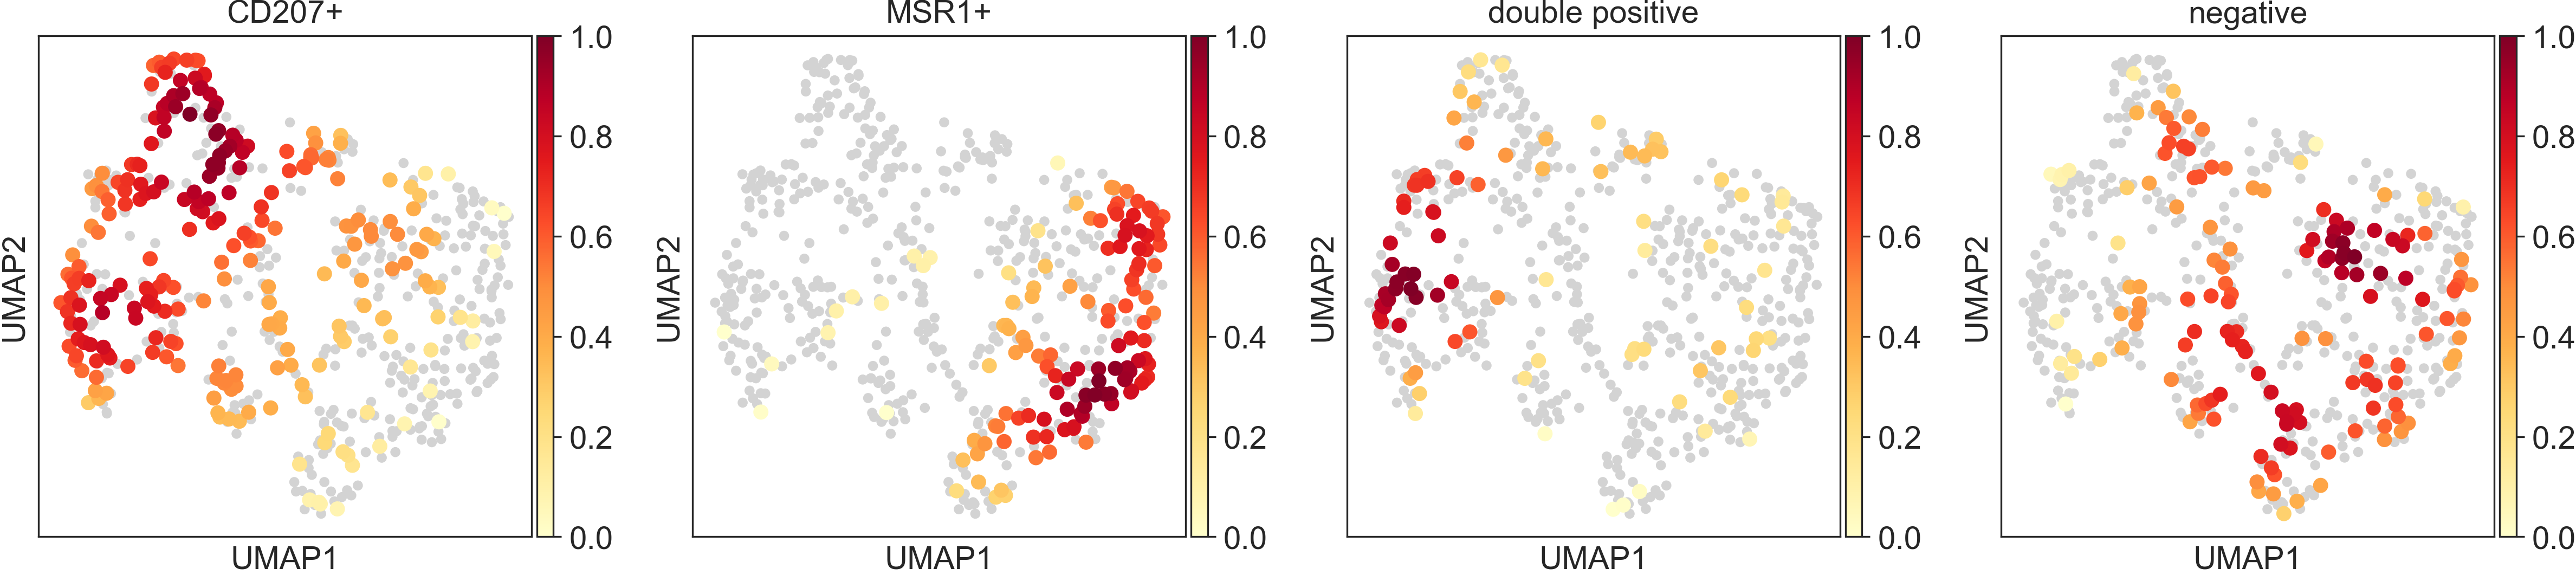

In [47]:
sc.tl.embedding_density(harmonized,groupby="state")
sc.pl.embedding_density(harmonized,groupby="state")

In [48]:
save_adata(harmonized, subdir="Myeloid",suffix="cDC2-state")